<a href="https://colab.research.google.com/github/cacomixtl/image-classification/blob/main/Stanford_Cars_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf

# Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
    # Optional: Print details about the GPU
    # for device in gpu_devices:
    #     tf.config.experimental.get_device_details(device)
else:
    print("No GPU detected. Please ensure you've selected GPU in Runtime > Change runtime type.")

# Set memory growth to True to avoid allocating all GPU memory at once (good practice)
try:
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled.")
except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(f"Error setting memory growth: {e}")

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2 # Example pre-trained models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder # Useful if labels are strings initially

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # OpenCV for potential image loading/manipulation if needed
import os # For interacting with the file system (paths)
import scipy.io # For loading .mat annotation files

# Set random seeds for reproducibility (optional but recommended)
np.random.seed(42)
tf.random.set_seed(42)

# Print library versions (good practice)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

TensorFlow Version: 2.18.0
Keras Version: 3.8.0
Scikit-learn Version: 1.6.1
Pandas Version: 2.2.2
NumPy Version: 2.0.2
OpenCV Version: 4.11.0


In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
import os
from pathlib import Path # Use pathlib for cleaner path manipulation
from typing import List, Tuple # For type hinting

# --- Configuration ---

# !!! IMPORTANT: EDIT THIS RELATIVE PATH !!!
# This should be the path *relative* to your Google Drive's root folder
# where the main 'Stanford_Cars_Dataset' top folder resides.
# Example: If your dataset is in 'MyDrive/Colab Notebooks/MyStanfordCars',
# this should be: 'Colab Notebooks/MyStanfordCars'
RELATIVE_DATASET_PATH_IN_DRIVE: str = 'Stanford_Cars_Dataset' # <--- EDIT THIS (Use your actual top folder name/path)

# --- Environment Assumptions ---
# Assumes running in an environment like Google Colab where Drive is mounted.
DRIVE_MOUNT_POINT: Path = Path('/content/drive/MyDrive/')

# --- Assumed Subdirectory Structure based on latest examples ---
# CSVs expected directly within: .../{RELATIVE_DATASET_PATH_IN_DRIVE}/
# Images expected within:       .../{RELATIVE_DATASET_PATH_IN_DRIVE}/car_data/car_dataset/[train|test]/...
IMAGE_SUBDIR_NESTING = Path('car_data') / 'car_dataset' # Nested structure for images

# --- Path Definitions ---
paths_defined = False
TOP_PROJECT_FOLDER = DRIVE_MOUNT_POINT / RELATIVE_DATASET_PATH_IN_DRIVE

# Check if the top project folder exists
if not DRIVE_MOUNT_POINT.exists():
    print(f"❌ ERROR: Google Drive mount point not found at '{DRIVE_MOUNT_POINT}'")
elif not TOP_PROJECT_FOLDER.exists():
     print(f"❌ ERROR: The top project folder specified does not exist!")
     print(f"   Specified relative path: '{RELATIVE_DATASET_PATH_IN_DRIVE}'")
     print(f"   Looked for absolute path: '{TOP_PROJECT_FOLDER}'")
     print(f"   Troubleshooting:")
     print(f"     1. Did you edit 'RELATIVE_DATASET_PATH_IN_DRIVE' correctly?")
     print(f"     2. Is the casing (uppercase/lowercase) correct?")
     print(f"     3. Is your Drive mounted?")
else:
    print(f"✅ Found Top Project Folder: '{TOP_PROJECT_FOLDER}'")

    # --- Define CSV Paths (directly under TOP_PROJECT_FOLDER) ---
    TRAIN_ANNOTATIONS_CSV: Path = TOP_PROJECT_FOLDER / 'anno_train.csv'
    TEST_ANNOTATIONS_CSV: Path = TOP_PROJECT_FOLDER / 'anno_test.csv'
    CLASS_NAMES_CSV: Path = TOP_PROJECT_FOLDER / 'names.csv'

    # --- Define Image Paths (under nested subdirectories) ---
    IMAGE_BASE_PATH: Path = TOP_PROJECT_FOLDER / IMAGE_SUBDIR_NESTING

    TRAIN_IMAGE_FOLDER: Path = IMAGE_BASE_PATH / 'train'
    # Example image path: TRAIN_IMAGE_FOLDER / 'Acura Integra Type R 2001' / '00128.jpg'

    TEST_IMAGE_FOLDER: Path = IMAGE_BASE_PATH / 'test'
    # Example image path: TEST_IMAGE_FOLDER / 'Aston Martin V8 Vantage Coupe 2012' / '00001.jpg'

    paths_defined = True # Mark paths as successfully defined

# --- Verification Function ---

def verify_dataset_paths(files_to_check: List[Path], folders_to_check: List[Path], top_folder: Path, image_nested_subdir: Path) -> bool:
    """
    Checks if all required files and folders exist at their specified paths.
    Requires the top_folder and image_nested_subdir paths for better error messages.
    """
    print(f"\n--- Verifying Specific File and Folder Paths ---")

    all_found = True
    required_items = files_to_check + folders_to_check

    if not required_items:
        print("⚠️ No files or folders provided for verification.")
        return False # Or True, depending on desired behavior for empty lists

    for item_path in required_items:
        is_expected_folder = item_path in folders_to_check
        is_expected_file = item_path in files_to_check
        item_type = "Folder" if is_expected_folder else "File"

        if item_path.exists():
            # Check if it's the correct type (file vs directory)
            if (is_expected_folder and not item_path.is_dir()) or \
               (is_expected_file and not item_path.is_file()):
                 print(f"  ❌ ERROR: Path exists but is not the correct type ({item_type}): {item_path}")
                 all_found = False
            else:
                print(f"  ✅ Found {item_type}: {item_path}")
        else:
            print(f"  ❌ ERROR: Missing {item_type}: {item_path}")
            all_found = False

    if all_found:
        print("\n✅ All required files and folders found at their specified locations.")
    else:
        print(f"\n❌ ERROR: Some required files/folders are missing or have the wrong type.")
        print(f"   Please check the paths printed above and your dataset structure.")
        print(f"   Ensure 'RELATIVE_DATASET_PATH_IN_DRIVE' points to the correct top-level folder ('{top_folder.name}').")
        print(f"   - CSV files (.csv) should be directly inside '{top_folder.name}'.")
        print(f"   - Image folders ('train', 'test') should be inside the nested structure: '{top_folder.name}/{image_nested_subdir}'.")

    return all_found

# --- Execute Verification ---
if paths_defined:
    # Create lists of the final paths to check
    required_files_list = [TRAIN_ANNOTATIONS_CSV, TEST_ANNOTATIONS_CSV, CLASS_NAMES_CSV]
    required_folders_list = [TRAIN_IMAGE_FOLDER, TEST_IMAGE_FOLDER]

    # Pass necessary info to verification function for clearer error messages
    paths_verified = verify_dataset_paths(
        required_files_list,
        required_folders_list,
        TOP_PROJECT_FOLDER,
        IMAGE_SUBDIR_NESTING
    )

    # Optional: Add further action based on verification
    # if not paths_verified:
    #     print("\nHalting execution due to path verification errors.")
    #     # raise FileNotFoundError("Dataset paths could not be verified.")

else:
    print("\nSkipping path verification because essential base paths could not be determined.")

✅ Found Top Project Folder: '/content/drive/MyDrive/Stanford_Cars_Dataset'

--- Verifying Specific File and Folder Paths ---
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/anno_train.csv
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/anno_test.csv
  ✅ Found File: /content/drive/MyDrive/Stanford_Cars_Dataset/names.csv
  ✅ Found Folder: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train
  ✅ Found Folder: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/test

✅ All required files and folders found at their specified locations.


# **Phase Two**

Phase 2.1

In [30]:
# --- Ensure these Variables are Correctly Set from Phase 1 ---
# Example definitions (MAKE SURE THESE MATCH YOUR ACTUAL PHASE 1 SETUP)
# DRIVE_MOUNT_POINT = '/content/drive/MyDrive/'
# YOUR_TOP_DATASET_FOLDER_PATH_IN_DRIVE = 'Your/Path/To/StanfordCars' # e.g., 'Colab Notebooks/Datasets/Stanford_Cars_Dataset'
# BASE_PROJECT_PATH = os.path.join(DRIVE_MOUNT_POINT, YOUR_TOP_DATASET_FOLDER_PATH_IN_DRIVE)
# BASE_IMAGE_PATH = os.path.join(BASE_PROJECT_PATH, 'car_data', 'car_dataset') # Path containing train/test folders
# TRAIN_ANNOTATIONS_CSV = os.path.join(BASE_PROJECT_PATH, 'anno_train.csv')
# TEST_ANNOTATIONS_CSV = os.path.join(BASE_PROJECT_PATH, 'anno_test.csv')
# CLASS_NAMES_CSV = os.path.join(BASE_PROJECT_PATH, 'names.csv')
#--------------------------------------------------------------

import os
import pandas as pd # Ensure pandas is imported

print("--- Verifying Essential Paths ---")

required_files = {
    "Train Annotations": TRAIN_ANNOTATIONS_CSV,
    "Test Annotations": TEST_ANNOTATIONS_CSV,
    "Class Names": CLASS_NAMES_CSV
}
required_dirs = {
    "Base Image Path": BASE_IMAGE_PATH,
    "Train Images Base": os.path.join(BASE_IMAGE_PATH, 'train'), # Dir containing class folders
    "Test Images Base": os.path.join(BASE_IMAGE_PATH, 'test')   # Dir containing class folders
}

all_paths_ok = True
for name, path in required_files.items():
    print(f"Checking File: {name} at {path}")
    if os.path.exists(path):
        print(" -> Found.")
    else:
        print(f" -> ERROR: File not found! Check path definition.")
        all_paths_ok = False

for name, path in required_dirs.items():
    print(f"Checking Directory: {name} at {path}")
    if os.path.exists(path):
        print(f" -> Found. Sample content: {os.listdir(path)[:3]}") # Show first 3 items
    else:
        print(f" -> ERROR: Directory not found! Check path definition.")
        all_paths_ok = False

if not all_paths_ok:
    print("\nERROR: One or more essential paths are incorrect. Please fix Phase 1 definitions before proceeding.")
else:
    print("\nEssential paths seem correct. Proceeding...")

# Define these base directories for image paths later
TRAIN_CLASSES_BASE_DIR = os.path.join(BASE_IMAGE_PATH, 'train')
TEST_CLASSES_BASE_DIR = os.path.join(BASE_IMAGE_PATH, 'test')

--- Verifying Essential Paths ---
Checking File: Train Annotations at /content/drive/MyDrive/Stanford_Cars_Dataset/anno_train.csv
 -> Found.
Checking File: Test Annotations at /content/drive/MyDrive/Stanford_Cars_Dataset/anno_test.csv
 -> Found.
Checking File: Class Names at /content/drive/MyDrive/Stanford_Cars_Dataset/names.csv
 -> Found.
Checking Directory: Base Image Path at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset
 -> Found. Sample content: ['test', 'train']
Checking Directory: Train Images Base at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train
 -> Found. Sample content: ['Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'Acura TL Type-S 2008']
Checking Directory: Test Images Base at /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/test
 -> Found. Sample content: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012']

Essential paths seem correct. Proceeding...


#2.2

In [31]:
# Define column names for annotation files (train/test)
anno_cols = ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id']

# Define column name for the class names file
names_col = ['class_name']

print("Column names defined:")
print(f"Annotation Columns: {anno_cols}")
print(f"Names Column: {names_col}")

Column names defined:
Annotation Columns: ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id']
Names Column: ['class_name']


#2.3

In [32]:
try:
    # Reload the CSV files specifying no header and assigning names
    train_annos_df = pd.read_csv(TRAIN_ANNOTATIONS_CSV, header=None, names=anno_cols)
    test_annos_df = pd.read_csv(TEST_ANNOTATIONS_CSV, header=None, names=anno_cols)
    class_names_df = pd.read_csv(CLASS_NAMES_CSV, header=None, names=names_col)

    print("--- Training Annotations (Loaded) ---")
    print(f"Shape: {train_annos_df.shape}")
    if train_annos_df.shape[0] == 8144: print(" -> Correct sample count.")
    else: print(f" -> Warning: Expected 8144 samples, got {train_annos_df.shape[0]}.")
    print(train_annos_df.head(3))

    print("\n--- Test Annotations (Loaded) ---")
    print(f"Shape: {test_annos_df.shape}")
    if test_annos_df.shape[0] == 8041: print(" -> Correct sample count.")
    else: print(f" -> Warning: Expected 8041 samples, got {test_annos_df.shape[0]}.")
    print(test_annos_df.head(3))

    print("\n--- Class Names (Loaded) ---")
    print(f"Shape: {class_names_df.shape}")
    if class_names_df.shape[0] == 196: print(" -> Correct class count.")
    else: print(f" -> Warning: Expected 196 classes, got {class_names_df.shape[0]}.")
    print(class_names_df.head(3))

except FileNotFoundError as e:
    print(f"Error loading CSV file: {e}")
    print("Please ensure the paths verified in Cell 2.1 are correct.")
except Exception as e:
    print(f"An error occurred during loading: {e}")

--- Training Annotations (Loaded) ---
Shape: (8144, 6)
 -> Correct sample count.
    filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id
0  00001.jpg       39      116      569      375        14
1  00002.jpg       36      116      868      587         3
2  00003.jpg       85      109      601      381        91

--- Test Annotations (Loaded) ---
Shape: (8041, 6)
 -> Correct sample count.
    filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id
0  00001.jpg       30       52      246      147       181
1  00002.jpg      100       19      576      203       103
2  00003.jpg       51      105      968      659       145

--- Class Names (Loaded) ---
Shape: (196, 1)
 -> Correct class count.
                   class_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012


#2.4

In [33]:
try:
    # Add a 'class_id' column (1-based index)
    class_names_df['class_id'] = class_names_df.index + 1

    print("--- Class Names with Added 'class_id' ---")
    print(class_names_df.head())
    print(f"\nMin class_id in names table: {class_names_df['class_id'].min()}")
    print(f"Max class_id in names table: {class_names_df['class_id'].max()}")

    # Check Class ID Range in Annotations
    min_train_id = train_annos_df['class_id'].min()
    max_train_id = train_annos_df['class_id'].max()
    min_test_id = test_annos_df['class_id'].min()
    max_test_id = test_annos_df['class_id'].max()
    print(f"\nTrain Annotation Class IDs range: {min_train_id} - {max_train_id}")
    print(f"Test Annotation Class IDs range: {min_test_id} - {max_test_id}")

    # Verify consistency
    if class_names_df['class_id'].max() != max(max_train_id, max_test_id):
         print("\nWarning: Max class ID in annotations doesn't match max ID in names file!")
    elif class_names_df['class_id'].min() != min(min_train_id, min_test_id):
         print("\nWarning: Min class ID in annotations doesn't match min ID in names file!")
    else:
        print("\nClass ID ranges appear consistent between names and annotations.")

except NameError:
     print("Error: Ensure train_annos_df, test_annos_df, class_names_df were loaded correctly in the previous cell.")
except KeyError as e:
     print(f"Error accessing expected column: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

--- Class Names with Added 'class_id' ---
                   class_name  class_id
0  AM General Hummer SUV 2000         1
1         Acura RL Sedan 2012         2
2         Acura TL Sedan 2012         3
3        Acura TL Type-S 2008         4
4        Acura TSX Sedan 2012         5

Min class_id in names table: 1
Max class_id in names table: 196

Train Annotation Class IDs range: 1 - 196
Test Annotation Class IDs range: 1 - 196

Class ID ranges appear consistent between names and annotations.


#2.5

In [34]:
try:
    # Merge train annotations with class names
    train_df = pd.merge(
        train_annos_df,
        class_names_df,
        on='class_id', # Merge on the common 'class_id' column
        how='left'     # Keep all annotations
    )

    # Merge test annotations with class names
    test_df = pd.merge(
        test_annos_df,
        class_names_df,
        on='class_id', # Merge on the common 'class_id' column
        how='left'
    )

    # Keep only necessary columns (drop bounding boxes etc.)
    keep_cols = ['filename', 'class_id', 'class_name']
    train_df = train_df[keep_cols]
    test_df = test_df[keep_cols]

    print("--- Merged Training DataFrame (Selected Columns) ---")
    print(f"Shape: {train_df.shape}")
    print(train_df.head())
    if train_df['class_name'].isnull().any():
        print(f"Warning: {train_df['class_name'].isnull().sum()} missing class names in train_df.")

    print("\n--- Merged Test DataFrame (Selected Columns) ---")
    print(f"Shape: {test_df.shape}")
    print(test_df.head())
    if test_df['class_name'].isnull().any():
        print(f"Warning: {test_df['class_name'].isnull().sum()} missing class names in test_df.")

except NameError:
     print("Error: Ensure train_annos_df, test_annos_df, class_names_df were loaded correctly.")
except KeyError as e:
     print(f"Error accessing expected column during merge: {e}")
except Exception as e:
    print(f"An error occurred during merge: {e}")

--- Merged Training DataFrame (Selected Columns) ---
Shape: (8144, 3)
    filename  class_id                           class_name
0  00001.jpg        14                  Audi TTS Coupe 2012
1  00002.jpg         3                  Acura TL Sedan 2012
2  00003.jpg        91           Dodge Dakota Club Cab 2007
3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012
4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012

--- Merged Test DataFrame (Selected Columns) ---
Shape: (8041, 3)
    filename  class_id                           class_name
0  00001.jpg       181              Suzuki Aerio Sedan 2007
1  00002.jpg       103  Ferrari 458 Italia Convertible 2012
2  00003.jpg       145                Jeep Patriot SUV 2012
3  00004.jpg       187              Toyota Camry Sedan 2012
4  00005.jpg       185             Tesla Model S Sedan 2012


#2.6

In [35]:
# CELL 2.6 (REVISED FOR PATHLIB)

import pandas as pd
from pathlib import Path # Ensure pathlib is imported if not already in scope

try:
    # TRAIN_CLASSES_BASE_DIR and TEST_CLASSES_BASE_DIR should be Path objects from Cell 2.1
    if not isinstance(TRAIN_CLASSES_BASE_DIR, Path) or not isinstance(TEST_CLASSES_BASE_DIR, Path):
         print("Warning: TRAIN_CLASSES_BASE_DIR or TEST_CLASSES_BASE_DIR are not Path objects. Converting.")
         TRAIN_CLASSES_BASE_DIR = Path(TRAIN_CLASSES_BASE_DIR)
         TEST_CLASSES_BASE_DIR = Path(TEST_CLASSES_BASE_DIR)

    if not TRAIN_CLASSES_BASE_DIR.exists() or not TEST_CLASSES_BASE_DIR.exists():
        raise FileNotFoundError("Base directories for train/test class folders not found. Check Cell 2.1.")

    print("Generating filepaths using pathlib...")
    # Create the correct filepath using pathlib's / operator
    # The resulting 'filepath' column will contain Path objects temporarily
    train_df['filepath'] = train_df.apply(
        lambda row: TRAIN_CLASSES_BASE_DIR / str(row['class_name']) / str(row['filename']) if pd.notna(row['class_name']) else None,
        axis=1
    )
    test_df['filepath'] = test_df.apply(
        lambda row: TEST_CLASSES_BASE_DIR / str(row['class_name']) / str(row['filename']) if pd.notna(row['class_name']) else None,
        axis=1
    )

    # Handle and report rows where filepath couldn't be generated
    num_missing_train_paths = train_df['filepath'].isnull().sum()
    num_missing_test_paths = test_df['filepath'].isnull().sum()
    if num_missing_train_paths > 0:
        print(f"Warning: Could not generate filepath for {num_missing_train_paths} training samples (likely missing class_name).")
    if num_missing_test_paths > 0:
        print(f"Warning: Could not generate filepath for {num_missing_test_paths} test samples (likely missing class_name).")

    # Drop rows with missing filepaths if they exist, as they cannot be used
    initial_train_count = len(train_df)
    initial_test_count = len(test_df)
    train_df = train_df.dropna(subset=['filepath'])
    test_df = test_df.dropna(subset=['filepath'])
    if len(train_df) < initial_train_count:
        print(f"Removed {initial_train_count - len(train_df)} training rows with missing filepaths.")
    if len(test_df) < initial_test_count:
        print(f"Removed {initial_test_count - len(test_df)} test rows with missing filepaths.")


    print("\n--- Training DataFrame with Final Filepath (Path Objects) ---")
    print(train_df.head()) # Note: filepath column contains Path objects now

    # --- Verification: Check one generated path using Path methods ---
    if not train_df.empty:
        # Ensure the column contains Path objects before accessing Path methods
        if pd.api.types.is_object_dtype(train_df['filepath']) and isinstance(train_df.iloc[0]['filepath'], Path):
             first_train_path_final_obj: Path = train_df.iloc[0]['filepath']
             print(f"\nChecking existence of first generated training image path: {first_train_path_final_obj}")
             print(f"Exists: {first_train_path_final_obj.exists()}") # Use Path.exists()
             if not first_train_path_final_obj.exists():
                  print("-> If path looks correct but still doesn't exist:")
                  print("   1. Double-check case sensitivity & exact names of class folders and image files.")
                  class_dir_path: Path = first_train_path_final_obj.parent # Use Path.parent
                  if class_dir_path.exists() and class_dir_path.is_dir():
                       # Use list comprehension with Path.name for cleaner output
                       contents = [p.name for p in class_dir_path.iterdir()]
                       print(f"   Actual contents of class directory '{class_dir_path.name}' (first 5): {contents[:5]}")
                  else:
                       print(f"   Class directory does not exist or is not a directory: {class_dir_path}")
        else:
             print("Warning: First filepath in DataFrame is not a Path object, cannot use Path methods for verification.")


    # --- Convert filepath column to string for broader compatibility ---
    # This ensures subsequent cells using libraries like matplotlib/cv2 work reliably
    print("\nConverting filepath column to string type...")
    train_df['filepath'] = train_df['filepath'].astype(str)
    test_df['filepath'] = test_df['filepath'].astype(str)
    print("Filepath column converted to string.")
    print("\n--- Training DataFrame with Final Filepath (String Type) ---")
    print(train_df.head())


except NameError as e:
     print(f"Error: Make sure train_df, test_df, TRAIN_CLASSES_BASE_DIR, TEST_CLASSES_BASE_DIR are defined: {e}")
except KeyError as e:
    print(f"Error: Missing column required for path generation: {e}. Need 'filename' and 'class_name'.")
except FileNotFoundError as e:
     print(f"Error: {e}") # Catch specific error from check
except ImportError:
     print("Error: Could not import pathlib. Make sure it's available.")
except Exception as e:
    print(f"An error occurred during filepath generation: {e}")

Generating filepaths using pathlib...

--- Training DataFrame with Final Filepath (Path Objects) ---
    filename  class_id                           class_name  \
0  00001.jpg        14                  Audi TTS Coupe 2012   
1  00002.jpg         3                  Acura TL Sedan 2012   
2  00003.jpg        91           Dodge Dakota Club Cab 2007   
3  00004.jpg       134     Hyundai Sonata Hybrid Sedan 2012   
4  00005.jpg       106  Ford F-450 Super Duty Crew Cab 2012   

                                            filepath  
0  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
1  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
2  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
3  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  
4  /content/drive/MyDrive/Stanford_Cars_Dataset/c...  

Checking existence of first generated training image path: /content/drive/MyDrive/Stanford_Cars_Dataset/car_data/car_dataset/train/Audi TTS Coupe 2012/00001.jpg
Exists: True

Converting fil

#2.7

In [36]:
try:
    num_train_images = len(train_df)
    num_test_images = len(test_df)
    num_classes_by_id = train_df['class_id'].nunique()
    num_classes_by_name = train_df['class_name'].nunique()

    print(f"\n--- Final Data Exploration ---")
    print(f"Number of usable training samples: {num_train_images}")
    print(f"Number of usable test samples: {num_test_images}")
    print(f"Number of unique classes by ID in training data: {num_classes_by_id}")
    print(f"Number of unique classes by Name in training data: {num_classes_by_name}")

    # Standard counts
    expected_train = 8144
    expected_test = 8041
    expected_classes = 196

    if num_train_images != expected_train: print(f"Warning: Train count ({num_train_images}) differs from expected ({expected_train}).")
    if num_test_images != expected_test: print(f"Warning: Test count ({num_test_images}) differs from expected ({expected_test}).")
    if num_classes_by_id != expected_classes: print(f"Warning: Class ID count ({num_classes_by_id}) differs from expected ({expected_classes}).")
    if num_classes_by_name != expected_classes: print(f"Warning: Class Name count ({num_classes_by_name}) differs from expected ({expected_classes}).")


except NameError:
    print("Error: Ensure train_df and test_df were created successfully.")
except KeyError as e:
    print(f"Error: Ensure the columns 'class_id' and 'class_name' exist.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Final Data Exploration ---
Number of usable training samples: 8144
Number of usable test samples: 8041
Number of unique classes by ID in training data: 196
Number of unique classes by Name in training data: 196


#2.8


--- Class Distribution Analysis (Final Training Set) ---
Total unique classes found: 196
Mean images per class: 41.55
Median images per class: 42.0
Min images per class: 24 (Class: Hyundai Accent Sedan 2012)
Max images per class: 68 (Class: GMC Savana Van 2012)


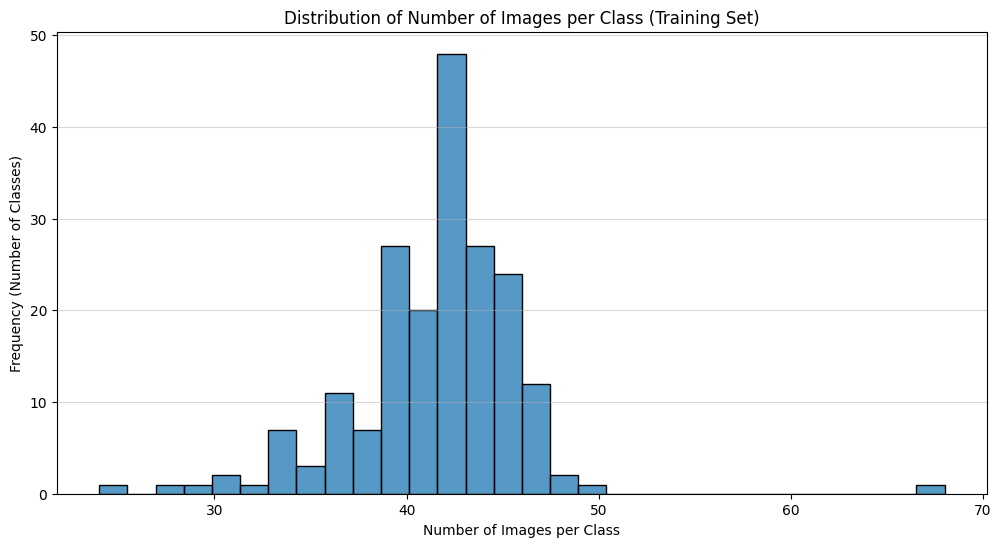


Top 10 Most Frequent Classes:
class_name
GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mitsubishi Lancer Sedan 2012                48
Mercedes-Benz 300-Class Convertible 1993    48
Jaguar XK XKR 2012                          47
Chevrolet Corvette ZR1 2012                 47
Volkswagen Golf Hatchback 1991              46
Nissan 240SX Coupe 1998                     46
Audi S6 Sedan 2011                          46
Bentley Continental GT Coupe 2007           46
Name: count, dtype: int64

Bottom 10 Least Frequent Classes:
class_name
BMW ActiveHybrid 5 Sedan 2012                          34
Infiniti QX56 SUV 2011                                 33
Bugatti Veyron 16.4 Convertible 2009                   33
Aston Martin Virage Convertible 2012                   33
Acura RL Sedan 2012                                    32
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach La

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported

try:
    print("\n--- Class Distribution Analysis (Final Training Set) ---")
    if not train_df.empty:
        class_counts = train_df['class_name'].value_counts()

        print(f"Total unique classes found: {len(class_counts)}")
        if not class_counts.empty:
            print(f"Mean images per class: {class_counts.mean():.2f}")
            print(f"Median images per class: {class_counts.median()}")
            print(f"Min images per class: {class_counts.min()} (Class: {class_counts.idxmin()})")
            print(f"Max images per class: {class_counts.max()} (Class: {class_counts.idxmax()})")

            # Plot distribution of counts
            plt.figure(figsize=(12, 6))
            sns.histplot(class_counts, bins=min(30, len(class_counts))) # Adjust bins if fewer classes
            plt.title('Distribution of Number of Images per Class (Training Set)')
            plt.xlabel('Number of Images per Class')
            plt.ylabel('Frequency (Number of Classes)')
            plt.grid(axis='y', alpha=0.5)
            plt.show()

            # Show Top N and Bottom N classes
            N = 10
            print(f"\nTop {N} Most Frequent Classes:")
            print(class_counts.head(N))

            print(f"\nBottom {N} Least Frequent Classes:")
            print(class_counts.tail(N))
        else:
            print("No data available for class distribution analysis.")
    else:
        print("Train DataFrame is empty. Skipping distribution analysis.")

except NameError:
    print("Error: Ensure train_df was created successfully.")
except KeyError:
     print(f"Error: Ensure the column 'class_name' exists in train_df.")
except Exception as e:
    print(f"An error occurred during distribution analysis: {e}")

#2.9


--- Visualizing Sample Images ---


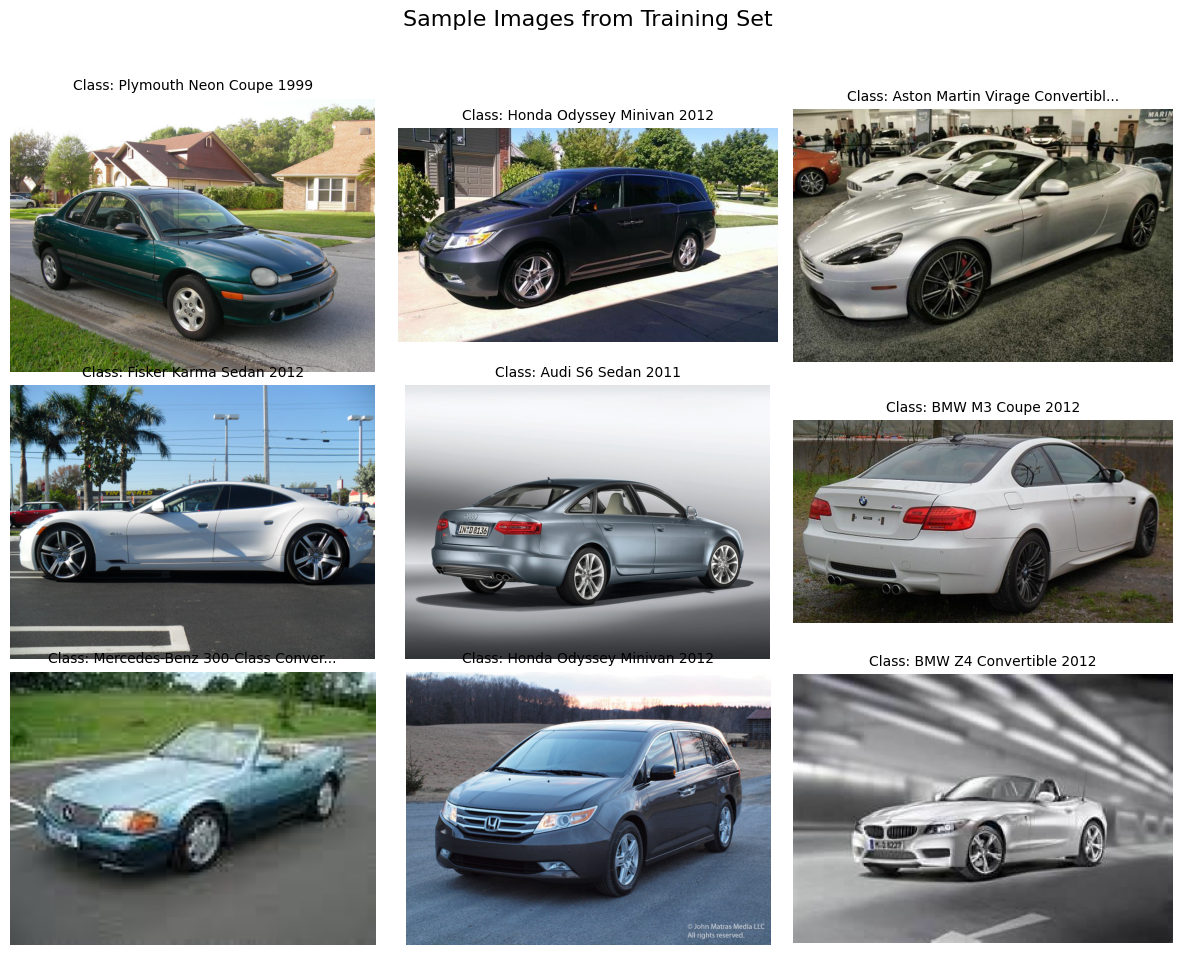

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import cv2 # Or use OpenCV if preferred

try:
    print("\n--- Visualizing Sample Images ---")
    if not train_df.empty:
        num_samples_to_show = 9
        # Sample from the potentially cleaned train_df
        sample_df = train_df.sample(min(num_samples_to_show, len(train_df)))

        plt.figure(figsize=(12, 10))
        plt.suptitle("Sample Images from Training Set", fontsize=16)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            img_path = row['filepath']
            img_label = row['class_name']

            plt.subplot(3, 3, i + 1) # Create a 3x3 grid
            try:
                img = mpimg.imread(img_path)
                # Or using OpenCV:
                # img = cv2.imread(img_path)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                plt.imshow(img)
                # Shorten label if too long for title
                display_label = (img_label[:30] + '...') if len(img_label) > 30 else img_label
                plt.title(f"Class: {display_label}", fontsize=10)
                plt.axis('off')
            except FileNotFoundError:
                print(f"Warning: Image not found at {img_path}")
                plt.title(f"Image not found\n{display_label}", fontsize=10)
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                plt.title(f"Error loading\n{display_label}", fontsize=10)
                plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Train DataFrame is empty. Skipping visualization.")

except NameError:
    print("Error: Ensure train_df was created successfully.")
except KeyError:
     print("Error: Ensure columns 'filepath' and 'class_name' exist in train_df.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")

#2.10

In [39]:
import cv2 # Using OpenCV here
import tqdm # For progress bar

try:
    print("\n--- Checking Image Dimensions (Sample) ---")
    unique_shapes = set()
    num_to_check = 50 # Check a small sample

    # Check some training images
    if not train_df.empty:
        print("Checking training images...")
        image_paths_to_check = train_df['filepath'].sample(min(num_to_check, len(train_df)))
        for filepath in tqdm.tqdm(image_paths_to_check):
            try:
                img = cv2.imread(filepath)
                if img is not None:
                    unique_shapes.add(img.shape)
                else:
                     print(f"\nWarning: Failed to read (cv2 returned None): {filepath}")
            except FileNotFoundError:
                 print(f"\nWarning: File not found during shape check: {filepath}") # Should be caught by earlier steps ideally
            except Exception as e:
                print(f"\nError reading {filepath} during shape check: {e}")
    else:
        print("Train DataFrame is empty. Skipping dimension check for train set.")

    # Check some test images (optional, usually train set is enough)
    # if not test_df.empty:
    #    print("Checking test images...")
    #    # Add similar loop for test_df['filepath'] if needed

    print(f"\nFound {len(unique_shapes)} unique image shapes (H, W, C) in the sample checked.")
    if len(unique_shapes) > 1:
        print(" -> Images have varying dimensions, resizing will be necessary.")
        print(f" -> Example shapes found: {list(unique_shapes)[:5]}") # Show first 5 found
    elif len(unique_shapes) == 1 and len(unique_shapes) > 0:
        print(f" -> All checked images have the same shape: {list(unique_shapes)[0]}")
    elif len(unique_shapes) == 0 and not train_df.empty:
         print(" -> Could not determine image shapes. Check warnings above - were images readable?")
    else:
         print(" -> No images checked or available.")


except NameError:
    print("Error: Ensure train_df and test_df were created successfully.")
except KeyError:
     print("Error: Ensure column 'filepath' exists.")
except ImportError:
     print("Error: Could not import cv2 or tqdm. Make sure they are installed.")
except Exception as e:
    print(f"An error occurred checking dimensions: {e}")


--- Checking Image Dimensions (Sample) ---
Checking training images...


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Found 41 unique image shapes (H, W, C) in the sample checked.
 -> Images have varying dimensions, resizing will be necessary.
 -> Example shapes found: [(1200, 1600, 3), (768, 1024, 3), (225, 300, 3), (480, 640, 3), (2448, 3264, 3)]
